In [1]:
%load_ext autoreload
from nb_config import *

### Plot LOB

In [2]:
import pickle
import matplotlib.pyplot as plt
from src.visualization.viz_orderbook1 import VizOrderbook1

In [3]:
viz = VizOrderbook1()

In [4]:
def get_step_from_time(d, t):
    for i, v in enumerate(d):
        if float(t) < float(v[0]):
            return i
    return len(d)

In [5]:
with open('snapshot_history.pkl', 'rb') as f:
    snapshot_history = pickle.load(f)

# Get all orders
all_orders = []
for elem in snapshot_history['limit_orders']:
    for o in elem[1]:
        all_orders.append(o[1])
print(all_orders[0])

25.58


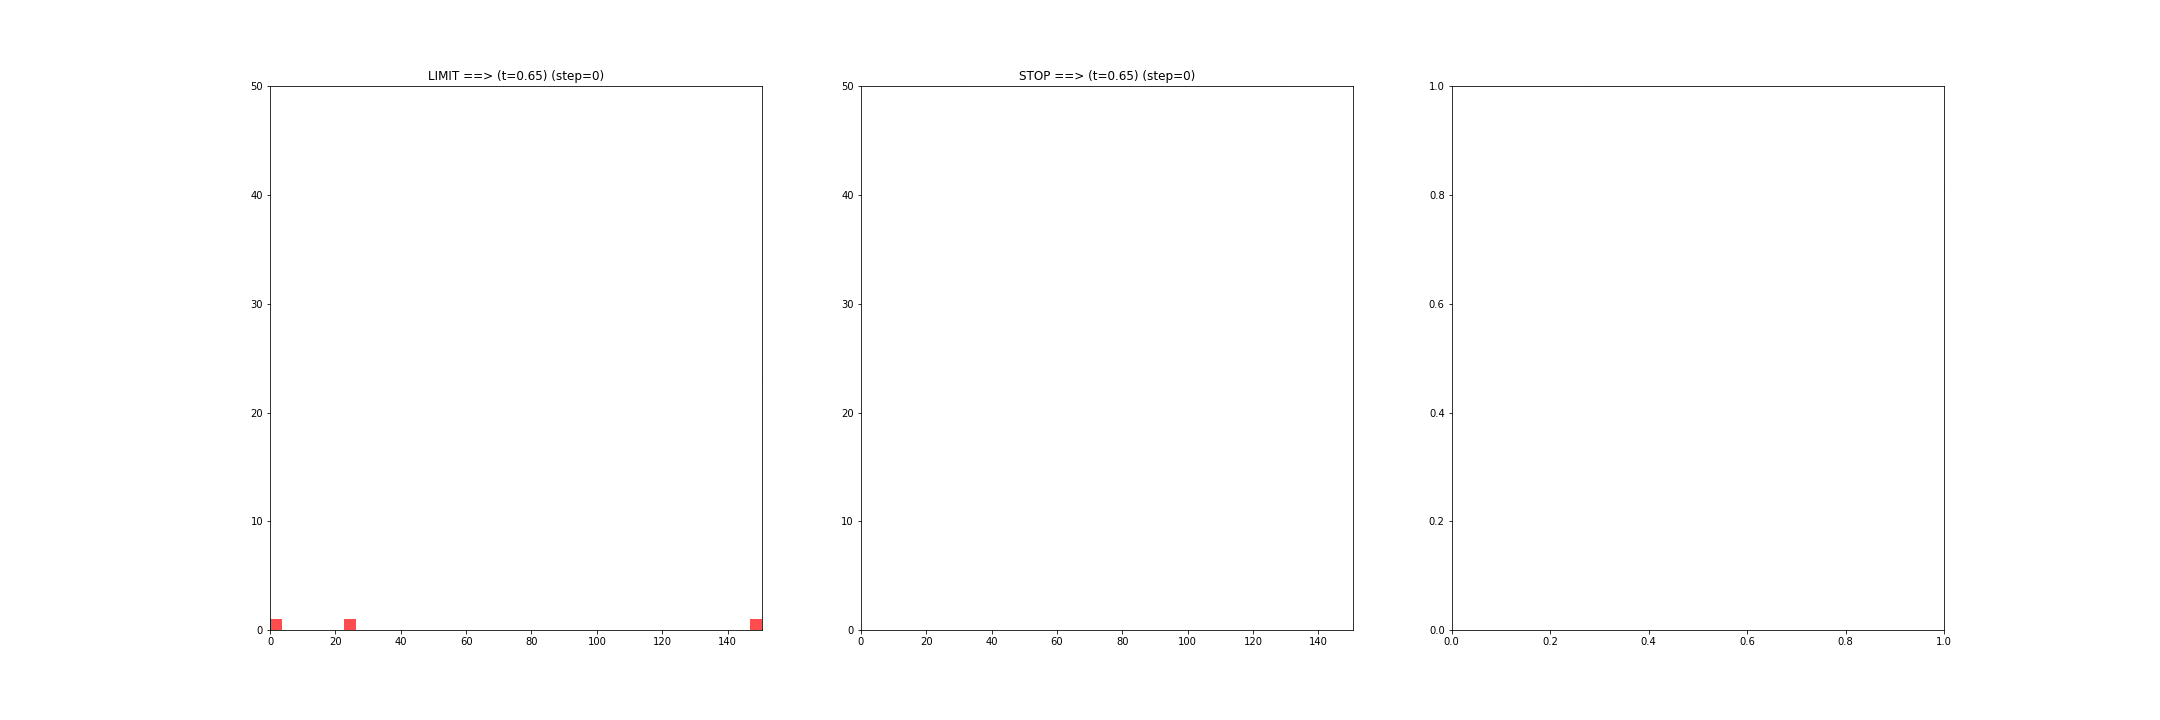

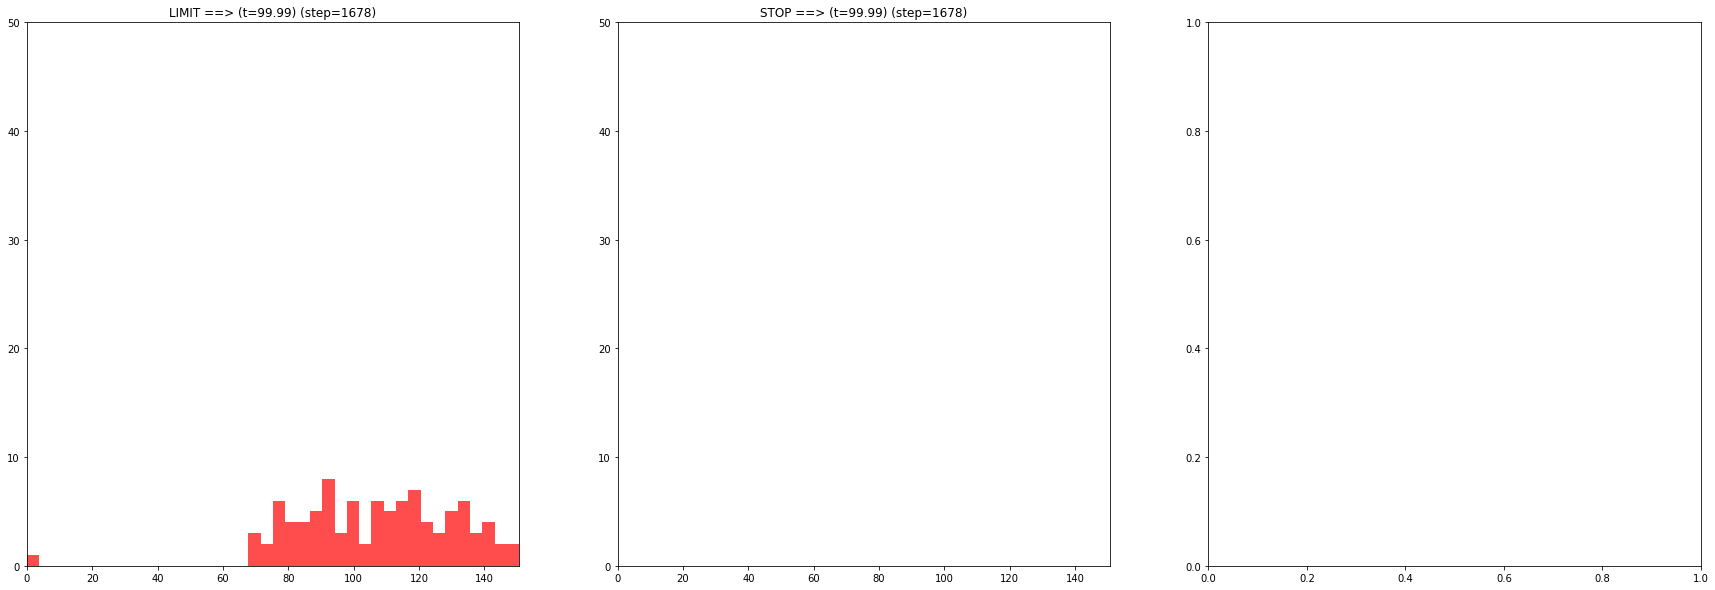

In [6]:
# Make plots
n_bins = 40
max_size = 50
frame_velocity=400
min_price, max_price = 0, max(all_orders)
left_time = 0

specific_steps =[int(i) for i in np.linspace(get_step_from_time(snapshot_history['limit_orders'], str(left_time)), 
                                             len(snapshot_history['limit_orders'])-1, 
                                             n_bins)]
# specific_steps = [10]

# Plot
ani, animate = viz.process(snapshot_history, 
                           specific_steps, 
                           n_bins, 
                           max_size, frame_velocity, min_price, max_price)
from IPython.display import Image
x = ani.save('orderbook.gif', writer='imagemagick')
Image(filename="orderbook.gif")

In [7]:
# help(animation.FuncAnimation)

In [8]:
# help(animation.FuncAnimation)
# help( plt.subplots)

In [9]:
# snapshot_history['limit_orders'][13][0]
# get_step_from_time(snapshot_history['limit_orders'], '10')
# specific_steps